In [17]:
!pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

In [19]:
# === 1. Pobranie danych ===
heart_failure = fetch_ucirepo(id=519)
X = heart_failure.data.features
y = heart_failure.data.targets.iloc[:, 0]

# Czyszczenie danych
X = X.drop_duplicates()
y = y.loc[X.index]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


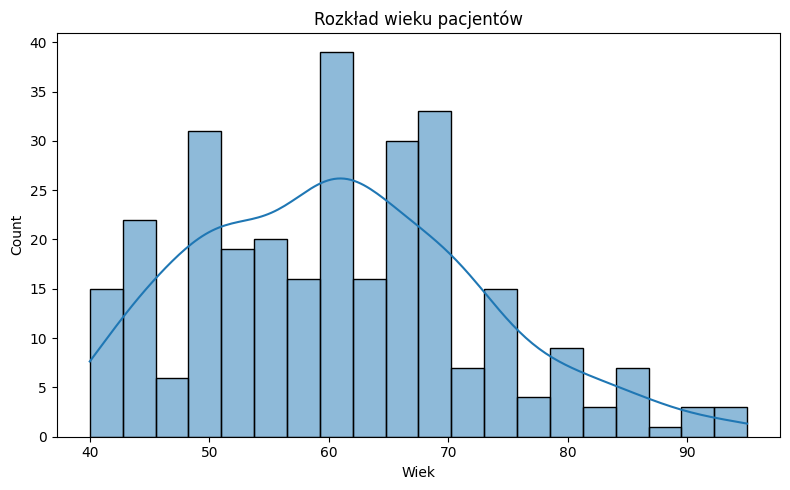

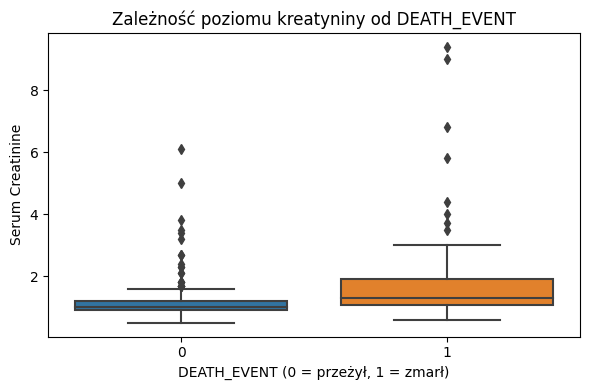

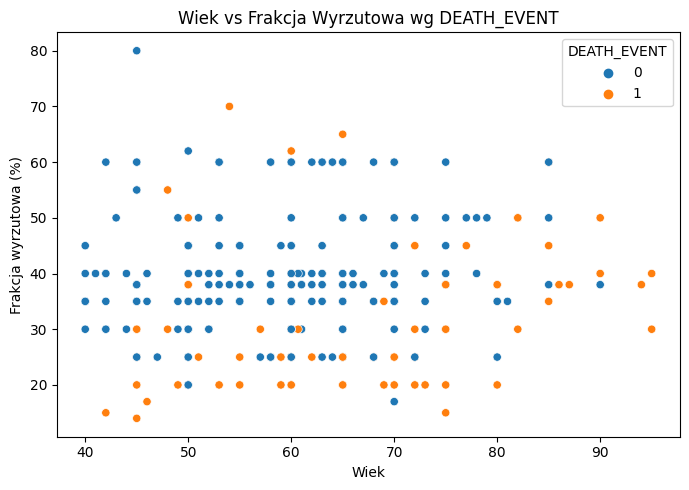

In [20]:
# === 2. Wizualizacje eksploracyjne ===
plt.figure(figsize=(8, 5))
sns.histplot(X["age"], bins=20, kde=True)
plt.title("Rozkład wieku pacjentów")
plt.xlabel("Wiek")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=y, y=X["serum_creatinine"])
plt.title("Zależność poziomu kreatyniny od DEATH_EVENT")
plt.xlabel("DEATH_EVENT (0 = przeżył, 1 = zmarł)")
plt.ylabel("Serum Creatinine")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X["age"], y=X["ejection_fraction"], hue=y)
plt.title("Wiek vs Frakcja Wyrzutowa wg DEATH_EVENT")
plt.xlabel("Wiek")
plt.ylabel("Frakcja wyrzutowa (%)")
plt.legend(title="DEATH_EVENT")
plt.tight_layout()
plt.show()

In [21]:
# === 3. Przygotowanie danych ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [22]:
# === 4. Definicja i kalibracja modeli ===
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
}

models = {
    name: CalibratedClassifierCV(estimator=clf, method="sigmoid", cv=5)
    for name, clf in base_models.items()
}


=== Logistic Regression ===
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        41
           1       0.85      0.58      0.69        19

    accuracy                           0.83        60
   macro avg       0.84      0.77      0.79        60
weighted avg       0.83      0.83      0.82        60



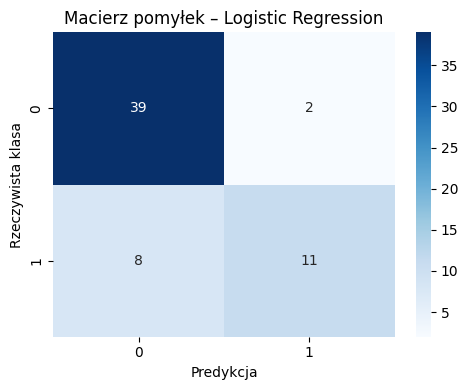

ROC AUC: 0.8575

=== Random Forest ===
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60



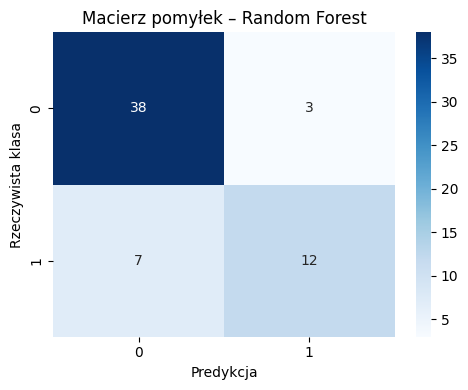

ROC AUC: 0.8999

=== SVM ===
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        41
           1       0.62      0.42      0.50        19

    accuracy                           0.73        60
   macro avg       0.69      0.65      0.66        60
weighted avg       0.72      0.73      0.72        60



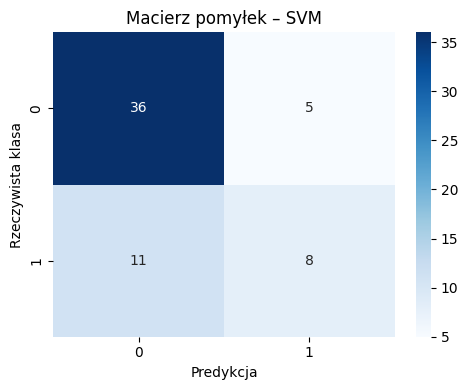

ROC AUC: 0.8408


In [23]:
# === 5. Trenowanie, ewaluacja i wizualizacja ===
model_results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Raport klasyfikacji:")
    print(classification_report(y_test, y_pred))

    # 🟦 Estetyczna macierz pomyłek
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predykcja")
    plt.ylabel("Rzeczywista klasa")
    plt.title(f"Macierz pomyłek – {name}")
    plt.tight_layout()
    plt.show()

    # ROC AUC i zapis do porównania
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.4f}")
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_results[name] = {"fpr": fpr, "tpr": tpr, "auc": auc}

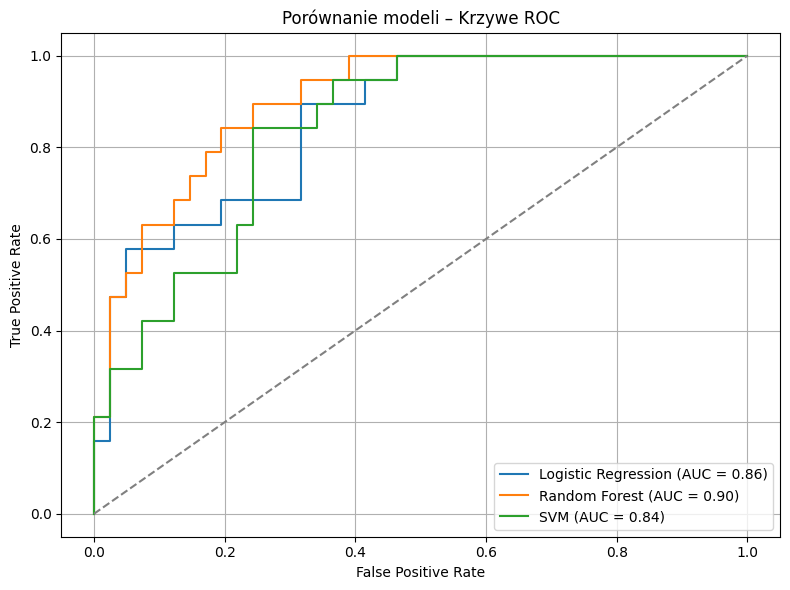

In [24]:
# === 6. Porównanie modeli – krzywe ROC ===
plt.figure(figsize=(8, 6))
for name, result in model_results.items():
    plt.plot(result["fpr"], result["tpr"], label=f"{name} (AUC = {result['auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Porównanie modeli – Krzywe ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()